In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/BayArea_GIS')
# scenario_name = 'high'

powertrain_lookup = {'Battery Electric': 'Electric',
                    'Diesel CI': 'Diesel',
                    'Flex Fuel': 'Other',
                    'Gasoline SI': 'Gasoline',
                    'H2 Fuel Cell': 'Electric',
                    'LPG': 'Other',
                    'Natural Gas': 'Other',
                    'PHEV Diesel': 'Electric',
                    'PHEV Gasoline':'Electric'}

truck_type_lookup = {'STRAIGHT TRUCK': 'Vocational',
                    'TRACTOR TRUCK': 'Tractor',
                    'CAB CHASSIS': 'Vocational',
                    'CUTAWAY': 'Vocational',
                    'INCOMPLETE (STRIP CHASSIS)': 'Vocational',
                    'STEP VAN': 'Vocational',
                    'VAN CARGO': 'Vocational',
                    'GLIDERS': 'Tractor'}

carrier_type_lookup = {'FOR HIRE': 'FOR HIRE',
                       'LOCAL GOVERNMENT (U.S. ONLY)': 'OTHER',
                       'PRIVATE': 'PRIVATE', 
                       'STATE GOVERNMENT (U.S. ONLY)': 'OTHER', 
                       'U.S. GOVERNMENT': 'OTHER', 
                       'DEALER': 'OTHER', 
                       'INDIVIDUAL': 'PRIVATE', 
                       'FINANCE LEASE': 'LEASE',
                       'MANUFACTURER SPONSORED LEASE': 'LEASE', 
                       'FULL SERVICE LEASE': 'LEASE', 
                       'VEHICLE MANUFACTURER': 'OTHER', 
                       'UTILITIES/COMMUNICATIONS': 'OTHER', 
                       'CANADIAN GOVERNMENT': 'OTHER'}


In [2]:
# Process Polk registration data by state --> current fleet composition
fleet_by_state = read_csv('registration/MDHDbyState.csv')

carrier_types = fleet_by_state.carrier_type.unique()
vehicle_types = fleet_by_state.vehicle_type.unique()
# print(carrier_types)
# print(vehicle_types)

# generate fleet attributes and clean data
fleet_by_state.loc[:, 'Weight class'] = 'Class 4-6'
fleet_by_state.loc[fleet_by_state['vin_gvw'].isin([7,8]), 'Weight class'] = 'Class 7&8'
fleet_by_state.loc[:, 'Body type'] = fleet_by_state.loc[:, 'vehicle_type'].map(truck_type_lookup)
fleet_by_state.loc[:, 'Service type'] = fleet_by_state.loc[:, 'carrier_type'].map(carrier_type_lookup)
fleet_by_state_filtered = fleet_by_state.dropna(subset = ['Body type'])

carrier_types = ['PRIVATE', 'FOR HIRE', 'LEASE']
fleet_by_state_filtered = \
fleet_by_state_filtered.loc[fleet_by_state_filtered['Service type'].isin(carrier_types)]
fleet_by_state_filtered.loc[:, 'vehicle type'] = \
fleet_by_state_filtered.loc[:, 'Weight class'] + ' ' + fleet_by_state_filtered.loc[:, 'Body type']
# fleet_by_state_filtered.head(5)

# summarize fleet by state
fleet_by_state_output = \
fleet_by_state_filtered.groupby(['state', 'Service type', 'vehicle type'])[['totcount']].sum()
fleet_by_state_output = fleet_by_state_output.reset_index()

fleet_by_state_output.loc[:, 'Truck_fraction'] = \
fleet_by_state_output.loc[:, 'totcount'] / \
fleet_by_state_output.groupby(['state', 'Service type'])['totcount'].transform('sum')

fleet_by_state_output = \
fleet_by_state_output.loc[fleet_by_state_output['vehicle type'] != 'Class 4-6 Tractor']
fleet_by_state_output.head(10)

,state,Service type,vehicle type,totcount,Truck_fraction
0,ALABAMA,FOR HIRE,Class 4-6 Vocational,1496,0.095057
1,ALABAMA,FOR HIRE,Class 7&8 Tractor,12711,0.807663
2,ALABAMA,FOR HIRE,Class 7&8 Vocational,1531,0.097280
3,ALABAMA,LEASE,Class 4-6 Vocational,2681,0.423807
4,ALABAMA,LEASE,Class 7&8 Tractor,2912,0.460322
5,ALABAMA,LEASE,Class 7&8 Vocational,733,0.115871
7,ALABAMA,PRIVATE,Class 4-6 Vocational,31592,0.412822
8,ALABAMA,PRIVATE,Class 7&8 Tractor,23249,0.303801
9,ALABAMA,PRIVATE,Class 7&8 Vocational,21644,0.282828
11,ALASKA,FOR HIRE,Class 4-6 Vocational,787,0.336038


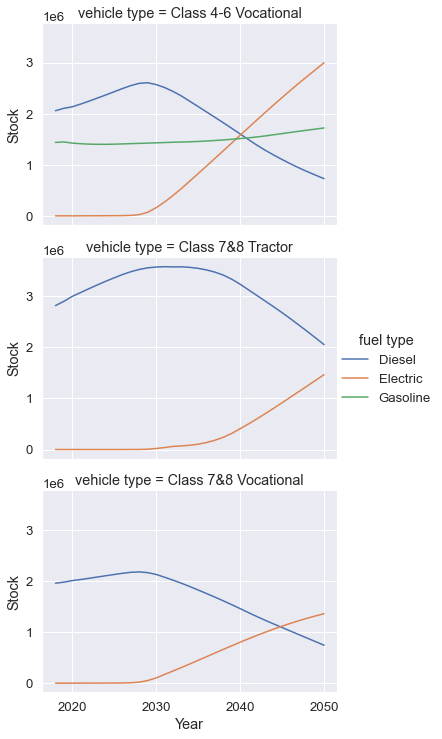

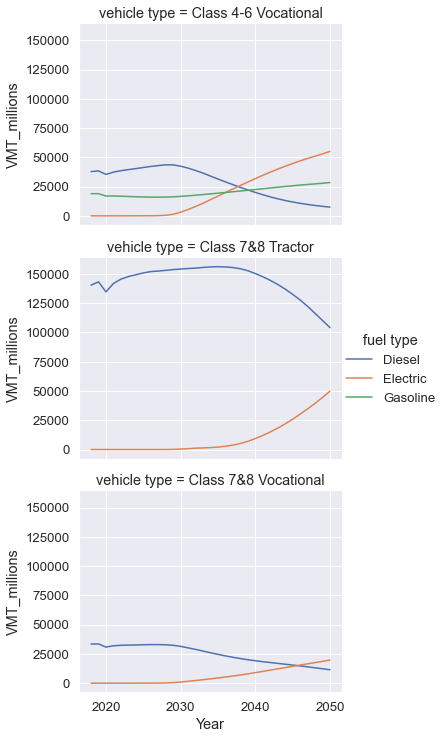

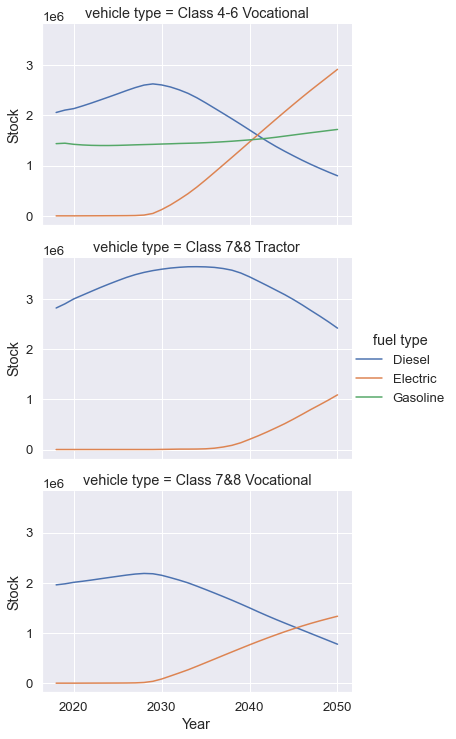

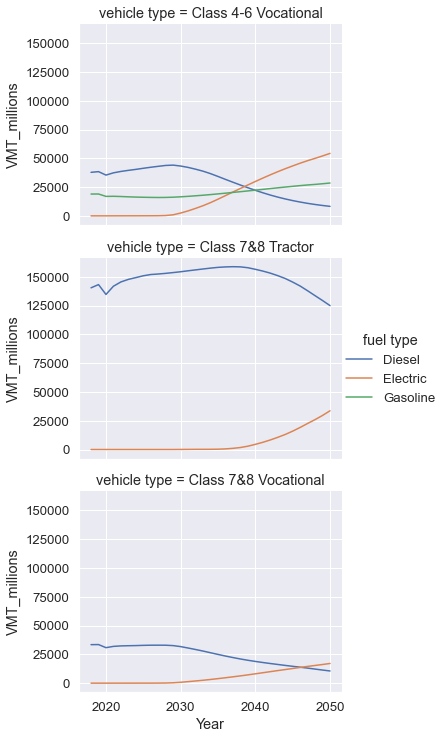

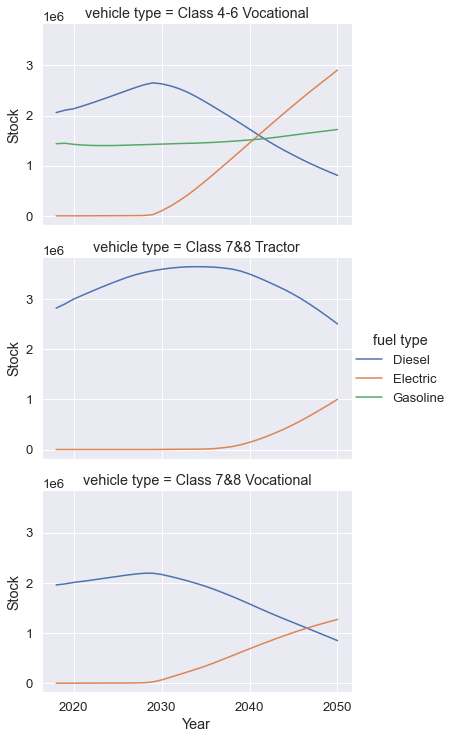

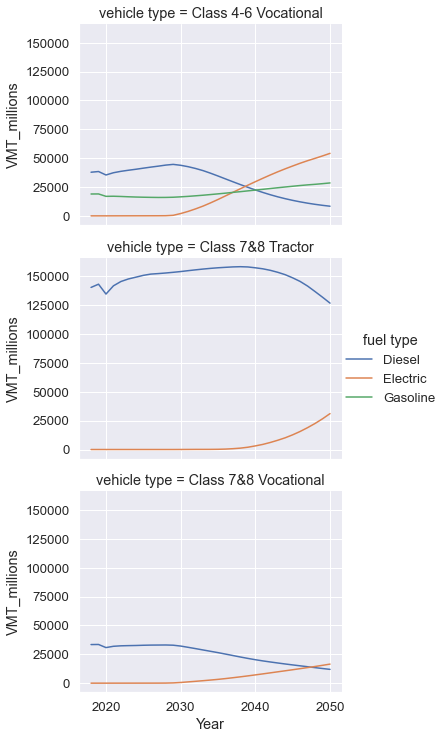

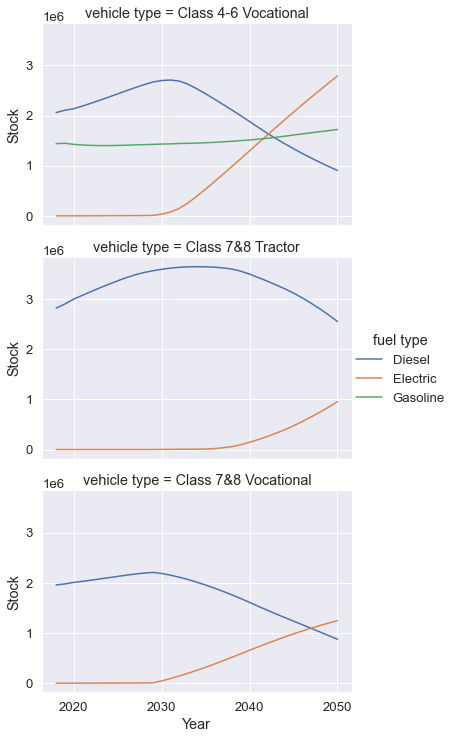

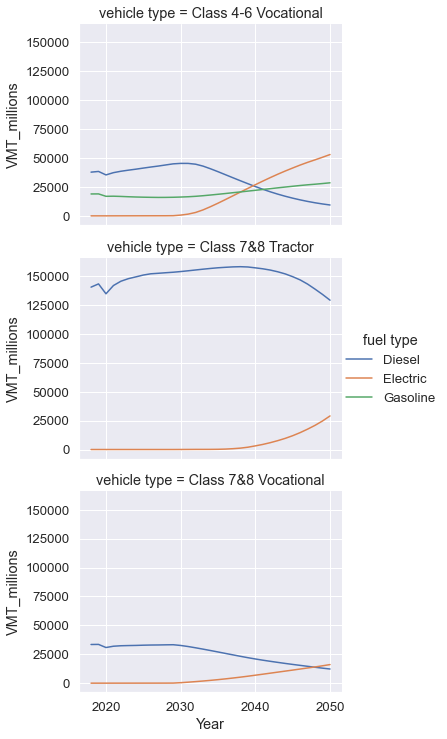

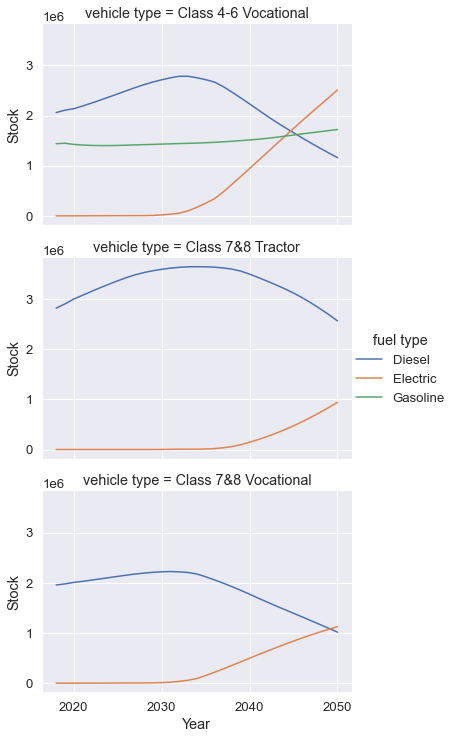

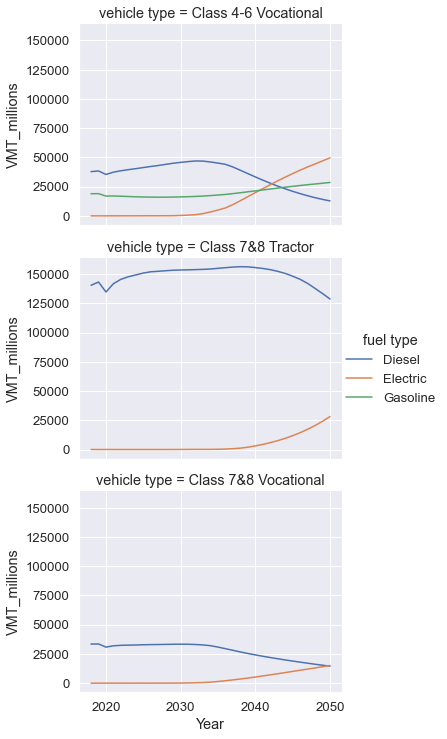

In [3]:
# process TDA results by scenario --> future projections

file_name = 'registration/TDA_results/BEAMFreightSensitivity_HOPmod.xlsx'
list_of_scenarios = ['HOP_highp2', 'HOP_highp4', 'HOP_highp6',
                    'HOP_highp8', 'HOP_highp10']
for scenario_name in list_of_scenarios:
    vehicle_stock = pd.read_excel(file_name, sheet_name = scenario_name)  
#     print(vehicle_stock.columns)
    # vehicle_stock = read_csv('registration/TDAResults.csv')
    # print(vehicle_stock.columns)
#     list_of_veh_class = vehicle_stock.Class.unique()
#     list_of_fuel_type = vehicle_stock.fuel_1.unique()

    # assign fleet attributes and clean data
    to_exclude = ['Class 3 Vocational', 'Class 3 Pickup and Van']
    vehicle_stock = vehicle_stock.loc[~vehicle_stock['Class'].isin(to_exclude)]

    vehicle_stock.loc[:, 'Body type'] = 'Vocational'
    tractor_types = ['Class 7&8 Sleeper Tractors', 'Class 7&8 Day Cab Tractors']
    vehicle_stock.loc[vehicle_stock['Class'].isin(tractor_types), 'Body type'] = 'Tractor'

    vehicle_stock.loc[:, 'Weight Class'] = 'Class 7&8'
    medium_duty_truck_type = ['Class 4-6 Vocational']
    vehicle_stock.loc[vehicle_stock['Class'].isin(medium_duty_truck_type), 'Weight Class'] = 'Class 4-6'

    vehicle_stock.loc[:, 'vehicle type'] = vehicle_stock.loc[:, 'Weight Class'] + ' ' + \
    vehicle_stock.loc[:, 'Body type']
    vehicle_stock.loc[:, 'fuel type'] = vehicle_stock.loc[:, 'Powertrain'].map(powertrain_lookup)

    # summarize results
    vehicle_stock_output = vehicle_stock.groupby(['Year', 'vehicle type', 'fuel type'])[['Stock', 'VMT_millions']].sum()
    vehicle_stock_output = vehicle_stock_output.reset_index()
    vehicle_stock_output = vehicle_stock_output.loc[vehicle_stock_output['fuel type'] != 'Other']

    vehicle_stock_output.loc[:, 'vehicle category'] = vehicle_stock_output.loc[:, 'fuel type'] + ' ' + \
    vehicle_stock_output.loc[:, 'vehicle type']

    to_drop = ['Gasoline Class 7&8 Tractor', 'Gasoline Class 7&8 Vocational']
    vehicle_stock_output = vehicle_stock_output.loc[~vehicle_stock_output['vehicle category'].isin(to_drop)]

    vehicle_stock_output.loc[:, 'Fraction'] = vehicle_stock_output.loc[:, 'Stock'] / \
    vehicle_stock_output.groupby(['Year', 'vehicle type'])['Stock'].transform('sum')
    
    # summarize EV fleet
    EV_stock = vehicle_stock.loc[vehicle_stock['fuel type'] == 'Electric']
    EV_stock_by_veh_type = EV_stock.groupby(['Year', 'vehicle type', 'Powertrain'])[['Stock']].sum()
    EV_stock_by_veh_type = EV_stock_by_veh_type.reset_index()
    EV_stock_by_veh_type = EV_stock_by_veh_type.loc[EV_stock_by_veh_type['Stock']>= 0]
    EV_stock_by_veh_type.loc[:, 'EV_fraction'] = EV_stock_by_veh_type.loc[:, 'Stock'] / \
    EV_stock_by_veh_type.groupby(['Year', 'vehicle type'])['Stock'].transform('sum')

    # generate future fleet composition by state
    fleet_by_state_output_2 = pd.merge(fleet_by_state_output,
                                 vehicle_stock_output,
                                 on = 'vehicle type', how = 'left')
    fleet_by_state_output_2.loc[:, 'veh_fraction'] = \
    fleet_by_state_output_2.loc[:, 'Truck_fraction'] * \
    fleet_by_state_output_2.loc[:, 'Fraction']
    fleet_by_state_output_2 = \
    fleet_by_state_output_2[['Year', 'state',	'Service type',	'vehicle type', 
                           'fuel type', 'vehicle category', 'veh_fraction']]
    
    # writing output
    # writing output
    output_path = 'registration/output/' + scenario_name
    isExist = os.path.exists(output_path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(output_path)
    fleet_by_state_output_2.to_csv(output_path + '/fleet_composition_by_state.csv', index = False)
    vehicle_stock_output.to_csv(output_path + '/TDA_vehicle_stock.csv', index = False)
    # EV_stock_output.to_csv('registration/output/' + scenario_name + '/EV_fraction_by_type.csv', index = False)
    EV_stock_by_veh_type.to_csv(output_path + '/EV_availability.csv', index = False)
    # visualize fleet composition
    vehicle_stock_agg_2 = vehicle_stock_output.groupby(['Year', 'vehicle type', 'fuel type'])[['Stock', 'VMT_millions']].sum()
    vehicle_stock_agg_2 = vehicle_stock_agg_2.reset_index()

    sns.relplot(
        data = vehicle_stock_agg_2, x = "Year", y = "Stock",
        row = 'vehicle type', hue = "fuel type", 
        kind="line", height = 3.5, aspect = 1.5
    )

    plt.savefig('registration/plot/TDA_fleet_by_year_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')

    sns.relplot(
        data = vehicle_stock_agg_2, x = "Year", y = "VMT_millions",
        row = 'vehicle type', hue = "fuel type", 
        kind="line", height = 3.5, aspect = 1.5
    )

    plt.savefig('registration/plot/TDA_VMT_by_year_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')
#     break
# vehicle_stock_output.head(10)

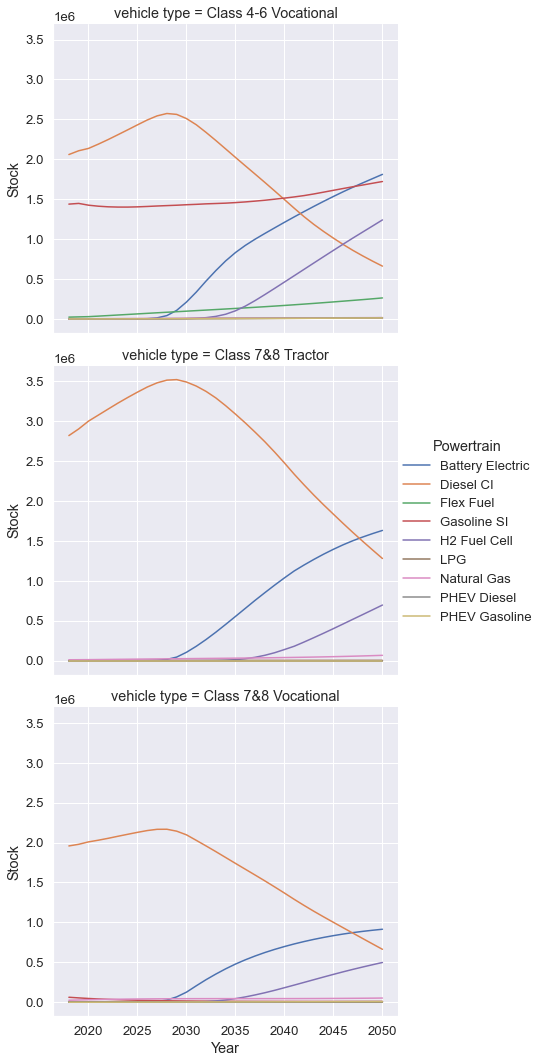

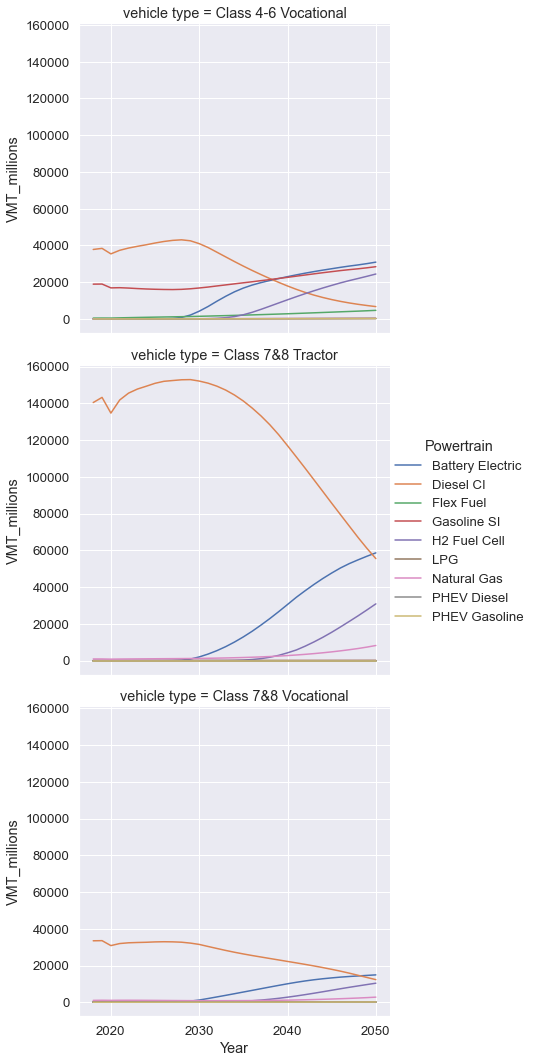

In [3]:
# no need at this point
vehicle_stock_agg = vehicle_stock.groupby(['Year', 'vehicle type', 'Powertrain'])[['Stock', 'VMT_millions']].sum()
vehicle_stock_agg = vehicle_stock_agg.reset_index()

sns.relplot(
    data = vehicle_stock_agg, x = "Year", y = "Stock",
    row = 'vehicle type', hue = "Powertrain", 
    kind="line", height = 5, aspect = 1.2
)

plt.savefig('registration/TDA_fleet_by_year_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')

sns.relplot(
    data = vehicle_stock_agg, x = "Year", y = "VMT_millions",
    row = 'vehicle type', hue = "Powertrain", 
    kind="line", height = 5, aspect = 1.2
)

plt.savefig('registration/TDA_vmt_by_year_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')

In [4]:


vehicle_stock.loc[:, 'fuel type'] = vehicle_stock.loc[:, 'Powertrain'].map(powertrain_lookup)
vehicle_stock.head(5)

vehicle_stock_output = vehicle_stock.groupby(['Year', 'vehicle type', 'fuel type'])[['Stock', 'VMT_millions']].sum()
vehicle_stock_output = vehicle_stock_output.reset_index()
vehicle_stock_output = vehicle_stock_output.loc[vehicle_stock_output['fuel type'] != 'Other']

vehicle_stock_output.loc[:, 'vehicle category'] = vehicle_stock_output.loc[:, 'fuel type'] + ' ' + \
vehicle_stock_output.loc[:, 'vehicle type']

to_drop = ['Gasoline Class 7&8 Tractor', 'Gasoline Class 7&8 Vocational']
vehicle_stock_output = vehicle_stock_output.loc[~vehicle_stock_output['vehicle category'].isin(to_drop)]

vehicle_stock_output.loc[:, 'Fraction'] = vehicle_stock_output.loc[:, 'Stock'] / \
vehicle_stock_output.groupby(['Year', 'vehicle type'])['Stock'].transform('sum')
vehicle_stock_output.head(10)

,Year,vehicle type,fuel type,Stock,VMT_millions,vehicle category,Fraction
0,2018,Class 4-6 Vocational,Diesel,2.059238e+06,37818.891867,Diesel Class 4-6 Vocational,0.588743
1,2018,Class 4-6 Vocational,Electric,1.010000e+02,2.274845,Electric Class 4-6 Vocational,0.000029
2,2018,Class 4-6 Vocational,Gasoline,1.438348e+06,18945.786780,Gasoline Class 4-6 Vocational,0.411228
4,2018,Class 7&8 Tractor,Diesel,2.818447e+06,140459.832888,Diesel Class 7&8 Tractor,0.999998
5,2018,Class 7&8 Tractor,Electric,6.000000e+00,0.128614,Electric Class 7&8 Tractor,0.000002
8,2018,Class 7&8 Vocational,Diesel,1.957950e+06,33450.774027,Diesel Class 7&8 Vocational,0.999999
9,2018,Class 7&8 Vocational,Electric,2.000000e+00,0.021436,Electric Class 7&8 Vocational,0.000001
12,2019,Class 4-6 Vocational,Diesel,2.106688e+06,38416.172924,Diesel Class 4-6 Vocational,0.592760
13,2019,Class 4-6 Vocational,Electric,1.009561e+02,2.088277,Electric Class 4-6 Vocational,0.000028
14,2019,Class 4-6 Vocational,Gasoline,1.447242e+06,18999.632337,Gasoline Class 4-6 Vocational,0.407211


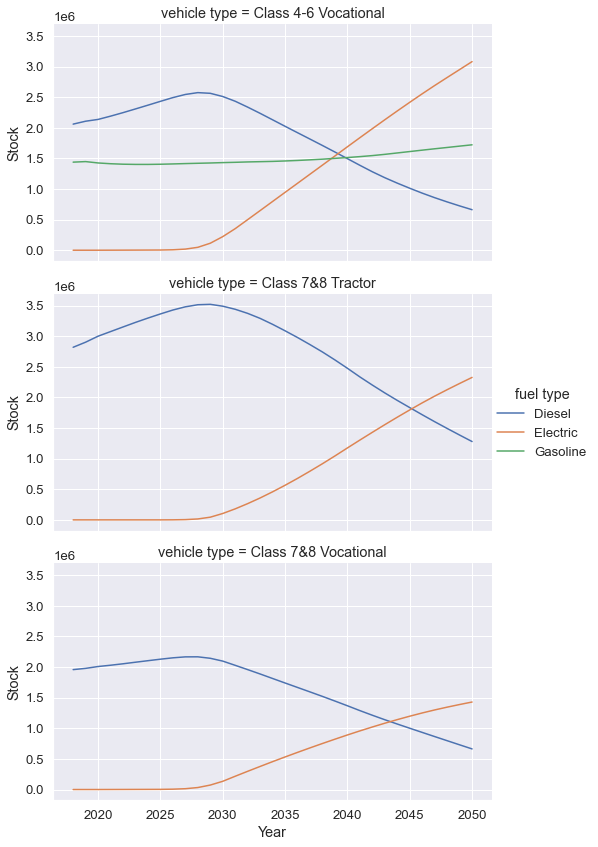

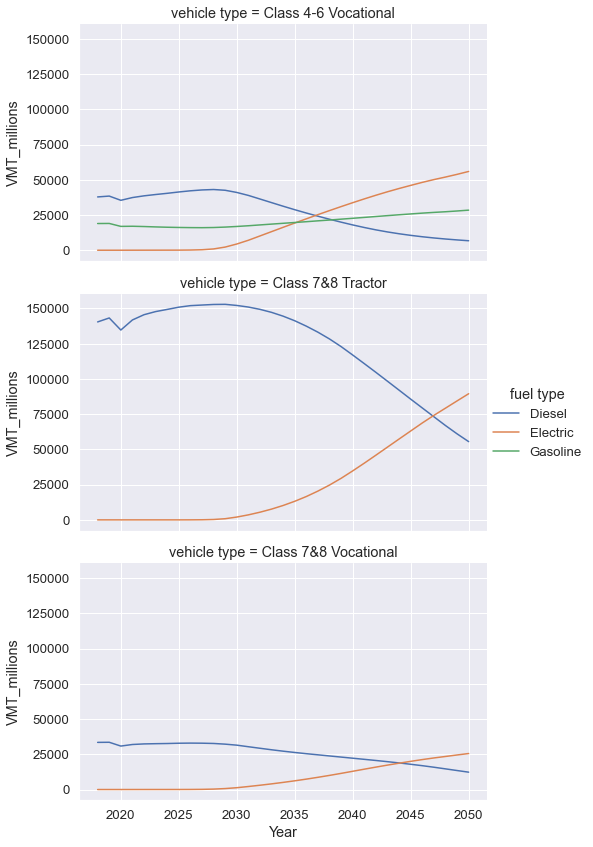

In [5]:
vehicle_stock_agg_2 = vehicle_stock_output.groupby(['Year', 'vehicle type', 'fuel type'])[['Stock', 'VMT_millions']].sum()
vehicle_stock_agg_2 = vehicle_stock_agg_2.reset_index()

sns.relplot(
    data = vehicle_stock_agg_2, x = "Year", y = "Stock",
    row = 'vehicle type', hue = "fuel type", 
    kind="line", height = 4, aspect = 1.8
)

plt.savefig('registration/plot/TDA_fleet_by_year_2_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')

sns.relplot(
    data = vehicle_stock_agg_2, x = "Year", y = "VMT_millions",
    row = 'vehicle type', hue = "fuel type", 
    kind="line", height = 4, aspect = 1.8
)

plt.savefig('registration/plot/TDA_VMT_by_year_2_' + scenario_name + '.png', dpi = 200, bbox_inches = 'tight')

In [6]:
# process EV classification
EV_stock = vehicle_stock.loc[vehicle_stock['fuel type'] == 'Electric']
EV_stock_output = EV_stock.groupby(['Year', 'Powertrain'])[['Stock']].sum()
EV_stock_output = EV_stock_output.reset_index()
EV_stock_output.loc[:, 'EV_fraction'] = EV_stock_output.loc[:, 'Stock'] / \
EV_stock_output.groupby('Year')['Stock'].transform('sum')
EV_stock_output.head(5)

,Year,Powertrain,Stock,EV_fraction
0,2018,Battery Electric,109.000000,1.0
1,2018,H2 Fuel Cell,0.000000,0.0
2,2018,PHEV Diesel,0.000000,0.0
3,2018,PHEV Gasoline,0.000000,0.0
4,2019,Battery Electric,108.956129,1.0


In [7]:
EV_stock_by_veh_type = EV_stock.groupby(['Year', 'vehicle type', 'Powertrain'])[['Stock']].sum()
EV_stock_by_veh_type = EV_stock_by_veh_type.reset_index()
EV_stock_by_veh_type = EV_stock_by_veh_type.loc[EV_stock_by_veh_type['Stock']>= 0]
EV_stock_by_veh_type.loc[:, 'EV_fraction'] = EV_stock_by_veh_type.loc[:, 'Stock'] / \
EV_stock_by_veh_type.groupby(['Year', 'vehicle type'])['Stock'].transform('sum')
EV_stock_by_veh_type.head(10)

,Year,vehicle type,Powertrain,Stock,EV_fraction
0,2018,Class 4-6 Vocational,Battery Electric,101.0,1.0
1,2018,Class 4-6 Vocational,H2 Fuel Cell,0.0,0.0
2,2018,Class 4-6 Vocational,PHEV Diesel,0.0,0.0
3,2018,Class 4-6 Vocational,PHEV Gasoline,0.0,0.0
4,2018,Class 7&8 Tractor,Battery Electric,6.0,1.0
5,2018,Class 7&8 Tractor,H2 Fuel Cell,0.0,0.0
6,2018,Class 7&8 Tractor,PHEV Diesel,0.0,0.0
7,2018,Class 7&8 Tractor,PHEV Gasoline,0.0,0.0
8,2018,Class 7&8 Vocational,Battery Electric,2.0,1.0
9,2018,Class 7&8 Vocational,H2 Fuel Cell,0.0,0.0


,state,Service type,vehicle type,totcount,Truck_fraction
0,ALABAMA,FOR HIRE,Class 4-6 Vocational,1496,0.095057
1,ALABAMA,FOR HIRE,Class 7&8 Tractor,12711,0.807663
2,ALABAMA,FOR HIRE,Class 7&8 Vocational,1531,0.097280
3,ALABAMA,LEASE,Class 4-6 Vocational,2681,0.423807
4,ALABAMA,LEASE,Class 7&8 Tractor,2912,0.460322
5,ALABAMA,LEASE,Class 7&8 Vocational,733,0.115871
7,ALABAMA,PRIVATE,Class 4-6 Vocational,31592,0.412822
8,ALABAMA,PRIVATE,Class 7&8 Tractor,23249,0.303801
9,ALABAMA,PRIVATE,Class 7&8 Vocational,21644,0.282828
11,ALASKA,FOR HIRE,Class 4-6 Vocational,787,0.336038


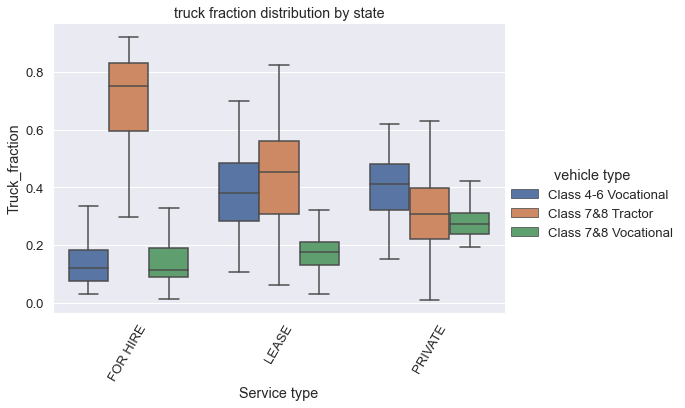

In [10]:
sns.catplot(data = fleet_by_state_output, 
            x = "Service type", 
            y = "Truck_fraction", 
            hue = "vehicle type", 
            kind = "box", showfliers = False, height = 5, aspect = 1.5)
plt.xticks(rotation = 60)
plt.title('truck fraction distribution by state')
plt.savefig('registration/POLK_fleet_by_state.png', dpi = 200, bbox_inches = 'tight')

In [11]:
fleet_by_state_output = pd.merge(fleet_by_state_output,
                                 vehicle_stock_output,
                                 on = 'vehicle type', how = 'left')
fleet_by_state_output.loc[:, 'veh_fraction'] = \
fleet_by_state_output.loc[:, 'Truck_fraction'] * fleet_by_state_output.loc[:, 'Fraction']
fleet_by_state_output = fleet_by_state_output[['Year', 'state',	'Service type',	'vehicle type', 'fuel type', 'vehicle category', 'veh_fraction']]
fleet_by_state_output.head(5)



,Year,state,Service type,vehicle type,fuel type,vehicle category,veh_fraction
0,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Diesel,Diesel Class 4-6 Vocational,0.055964
1,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Electric,Electric Class 4-6 Vocational,0.000003
2,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Gasoline,Gasoline Class 4-6 Vocational,0.039090
3,2019,ALABAMA,FOR HIRE,Class 4-6 Vocational,Diesel,Diesel Class 4-6 Vocational,0.056346
4,2019,ALABAMA,FOR HIRE,Class 4-6 Vocational,Electric,Electric Class 4-6 Vocational,0.000003


In [12]:
# writing output 
fleet_by_state_output.to_csv('registration/output/' + scenario_name + '/fleet_composition_by_state.csv', index = False)
vehicle_stock_output.to_csv('registration/output/' + scenario_name + '/TDA_vehicle_stock.csv', index = False)
# EV_stock_output.to_csv('registration/output/' + scenario_name + '/EV_fraction_by_type.csv', index = False)
EV_stock_by_veh_type.to_csv('registration/output/' + scenario_name + '/EV_availability.csv', index = False)